In [1]:
import rasterio
import numpy as np
import h3ronpy
from h3ronpy.raster import nearest_h3_resolution
from h3ronpy.pandas.raster import raster_to_dataframe
from matplotlib import pyplot as plt
import pandas as pd
import h3
import copy
from rasterio.warp import calculate_default_transform, reproject, Resampling
import os
from scipy.optimize import minimize_scalar, minimize
from shapely.geometry import Polygon
from shapely import wkt
import geopandas as gpd

In [2]:
# amewoo, lobcur, buwtea, tunswa, sursco, bkpwar, sheowl, snoowl1
species = 'amewoo'

In [ ]:
try:
    df = pd.read_csv(f'{species}/tables/h3_abundance.csv')
    df['geometry'] = df['geometry'].apply(wkt.loads)
    df = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")
    m = df['value_breeding'].median()
    filtered_df = df[((df['value_breeding'] - m) > 0.01 * m)]
    breeding_favorite_threshold = filtered_df['value_breeding'].median()
except (FileNotFoundError, pd.errors.EmptyDataError):
    print("here we go again")

In [ ]:
resolution = 4 #change to 3
elevation_limit = 2000

# Reading raster and creating h3 abundance map

In [ ]:
resolution_factor = 0.1

# Define bounding box in EPSG:432.
bounds = (-170, -60, -30, 85)

In [ ]:
os.makedirs(f"{species}/plots", exist_ok=True)
os.makedirs(f"{species}/tables", exist_ok=True)

In [6]:
# abundance files from ebird
wintering_tif_path = f"{species}/{species}_abundance_seasonal_nonbreeding_mean_2023.tif"
breeding_tif_path = f"{species}/{species}_abundance_seasonal_breeding_mean_2023.tif"

In [7]:
rasters = {
    "wintering": rasterio.open(wintering_tif_path),
    "breeding": rasterio.open(breeding_tif_path),
}

Crop to North America only

In [ ]:
from rasterio.windows import from_bounds
from rasterio.warp import transform_bounds

def reproject_downsample_and_crop(src, dst_crs="EPSG:4326", resolution_factor=1.0, 
                                 bounds=None, resampling=Resampling.nearest):
    """Reproject, downsample and crop in one operation.
    
    Args:
        src: rasterio dataset
        dst_crs: target CRS
        resolution_factor: factor to decrease resolution
        bounds: tuple of (left, bottom, right, top) to crop to
        resampling: resampling method
        
    Returns:
        tuple: (processed_array, new_transform)
    """
    # If bounds provided, first calculate transform for the area of interest
    if bounds:
        # Transform bounds to source CRS if needed
        if dst_crs != src.crs:
            from rasterio.warp import transform_bounds
            src_bounds = transform_bounds(dst_crs, src.crs, *bounds)
        else:
            src_bounds = bounds
            
        # Calculate transform for the specific bounds
        dst_transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src_bounds
        )
    else:
        # Calculate transform for entire raster
        dst_transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height,
            left=src.bounds.left, bottom=src.bounds.bottom,
            right=src.bounds.right, top=src.bounds.top
        )
    
    # Apply resolution reduction
    new_width = int(width * resolution_factor)
    new_height = int(height * resolution_factor)
    
    # Scale the transform
    scaled_transform = dst_transform * dst_transform.scale(1/resolution_factor)
    
    # Create destination array
    dst_arr = np.empty((new_height, new_width), dtype=src.meta["dtype"])
    
    # Reproject with potential window reading for efficiency
    if bounds and src_bounds:
        # Read only the window of interest for large rasters
        window = from_bounds(*src_bounds, transform=src.transform)
        src_data = src.read(1, window=window)
        src_window_transform = src.window_transform(window)
    else:
        src_data = src.read(1)
        src_window_transform = src.transform
    
    reproject(
        source=src_data,
        destination=dst_arr,
        src_transform=src_window_transform,
        src_crs=src.crs,
        dst_transform=scaled_transform,
        dst_crs=dst_crs,
        resampling=resampling
    )
    
    return dst_arr, scaled_transform



In [ ]:
breeding_arr, breeding_transform = reproject_downsample_and_crop(
    rasters["breeding"],
    resolution_factor=resolution_factor,
    bounds=bounds,
    resampling=Resampling.average
)

wintering_arr, wintering_transform = reproject_downsample_and_crop(
    rasters["wintering"],
    resolution_factor=resolution_factor,
    bounds=bounds,
    resampling=Resampling.average
)

In [ ]:
# raster plots after transforming and cropping

# Downsample raster to avoid huge memory usage
factor = 10  # adjust as needed
arr_small = breeding_arr[::factor, ::factor]

plt.figure(figsize=(12, 8))
plt.imshow(arr_small, cmap="viridis", origin="upper")
plt.colorbar(label="Value")
plt.title("Breeding Raster (Downsampled)")

plt.savefig(f"{species}/plots/breeding_raster.pdf", dpi=300, bbox_inches="tight")
plt.close()

In [ ]:
# Downsample raster to avoid huge memory usage
factor = 10  # adjust as needed
arr_small = wintering_arr[::factor, ::factor]

plt.figure(figsize=(12, 8))
plt.imshow(arr_small, cmap="viridis", origin="upper")
plt.colorbar(label="Value")
plt.title("Wintering Raster (Downsampled)")

plt.savefig(f"{species}/plots/wintering_raster.pdf", dpi=300, bbox_inches="tight")
plt.close()

In [18]:
h3_res_b = nearest_h3_resolution(breeding_arr.shape, breeding_transform, search_mode="smaller_than_pixel")
h3_res_w = nearest_h3_resolution(wintering_arr.shape, wintering_transform, search_mode="smaller_than_pixel")

print(f"Using H3 resolution {h3_res_b} for breeding, {h3_res_w} for wintering")

Using H3 resolution 6 for breeding, 6 for wintering


In [19]:
# nodata_value = nan doesn't seem to work correctly
breeding_h3_df = raster_to_dataframe(
    breeding_arr,
    breeding_transform,
    h3_resolution=h3_res_b,
    # nodata_value=nodata_values['breeding'],
    compact=False,
    geo=True
)

In [20]:
wintering_h3_df = raster_to_dataframe(
    wintering_arr,
    wintering_transform,
    h3_resolution=h3_res_w,
    # nodata_value=nodata_values['wintering'],
    compact=False,
    geo=True
)

In [60]:
breeding_h3_df.head()

NameError: name 'breeding_h3_df' is not defined

In [22]:
df_orig = breeding_h3_df.merge(
    wintering_h3_df[["cell", "value"]],
    on="cell",
    how="outer",
    suffixes=("_breeding", "_wintering")
)

In [23]:
# Drop rows where both values are zero or nans
df_orig["value_breeding"] = df_orig["value_breeding"].fillna(0)
df_orig["value_wintering"] = df_orig["value_wintering"].fillna(0)
df_orig = df_orig[(df_orig["value_breeding"] != 0) | (df_orig["value_wintering"] != 0)]

In [24]:
df_orig.head()

,value_breeding,cell,geometry,value_wintering
109437,0.001638,603518095335620607,"POLYGON ((-98.63015 76.7132, -98.7542 76.6928,...",0.0
109527,0.004352,603518111307530239,"POLYGON ((-98.85522 76.60484, -98.97799 76.584...",0.0
109538,0.012087,603518112918142975,"POLYGON ((-99.92207 76.67502, -100.04369 76.65...",0.0
110108,0.016821,603518230492872703,"POLYGON ((-101.90305 76.24321, -102.0179 76.22...",0.0
110115,0.010530,603518231566614527,"POLYGON ((-101.35652 76.1621, -101.47166 76.14...",0.0


In [25]:
# Suppose df has fine-resolution cells
df_orig["parent"] = h3ronpy.change_resolution(df_orig["cell"], resolution).to_numpy()


In [26]:
df_orig.head()

,value_breeding,cell,geometry,value_wintering,parent
109437,0.001638,603518095335620607,"POLYGON ((-98.63015 76.7132, -98.7542 76.6928,...",0.0,594510902120677375
109527,0.004352,603518111307530239,"POLYGON ((-98.85522 76.60484, -98.97799 76.584...",0.0,594510919300546559
109538,0.012087,603518112918142975,"POLYGON ((-99.92207 76.67502, -100.04369 76.65...",0.0,594510919300546559
110108,0.016821,603518230492872703,"POLYGON ((-101.90305 76.24321, -102.0179 76.22...",0.0,594511039559630847
110115,0.010530,603518231566614527,"POLYGON ((-101.35652 76.1621, -101.47166 76.14...",0.0,594511039559630847


In [27]:
df_inter = df_orig.groupby("parent", as_index=False).agg({
    "value_wintering": "sum",
    "value_breeding": "sum"
})


In [28]:
df_inter['cell'] = df_inter['parent'].apply(lambda x: '{:x}'.format(x))

In [29]:
df_inter.head()

,parent,value_wintering,value_breeding,cell
0,594510902120677375,0.0,0.001638,8402083ffffffff
1,594510919300546559,0.0,0.016439,8402087ffffffff
2,594511039559630847,0.0,0.039680,84020a3ffffffff
3,594511073919369215,0.0,0.000252,84020abffffffff
4,594511099689172991,0.0,0.027776,84020b1ffffffff


In [30]:
def swap_coords(coords):
    return [(lon, lat) for lat, lon in coords]

In [31]:
df_inter["geometry"] = df_inter["cell"].apply(lambda c: Polygon(swap_coords(h3.cell_to_boundary(c))))

In [32]:
df_inter.head()

,parent,value_wintering,value_breeding,cell,geometry
0,594510902120677375,0.0,0.001638,8402083ffffffff,POLYGON ((-97.78714909530665 76.98919705288482...
1,594510919300546559,0.0,0.016439,8402087ffffffff,POLYGON ((-99.63407604521291 76.93946782048393...
2,594511039559630847,0.0,0.039680,84020a3ffffffff,POLYGON ((-102.16491606564018 76.4897264419451...
3,594511073919369215,0.0,0.000252,84020abffffffff,POLYGON ((-101.46114901595277 76.8769009047930...
4,594511099689172991,0.0,0.027776,84020b1ffffffff,POLYGON ((-99.36644796871836 76.23135082064368...


In [33]:
df = gpd.GeoDataFrame(df_inter.drop(columns=["parent"]), geometry="geometry", crs="EPSG:4326")

In [34]:
# Normalization
total_breeding = df["value_breeding"].sum()
total_wintering = df["value_wintering"].sum()

df["value_breeding"] = df["value_breeding"] / total_breeding
df["value_wintering"] = df["value_wintering"] / total_wintering


# можно ли нормализовать так, чтобы для территорий, в которых  есть наблюдения в оба сезона, вес был один и тот же? надо ли

In [ ]:
m = df['value_breeding'].median()
filtered_df = df[((df['value_breeding'] - m) > 0.01 * m)]
breeding_favorite_threshold = filtered_df['value_breeding'].median()

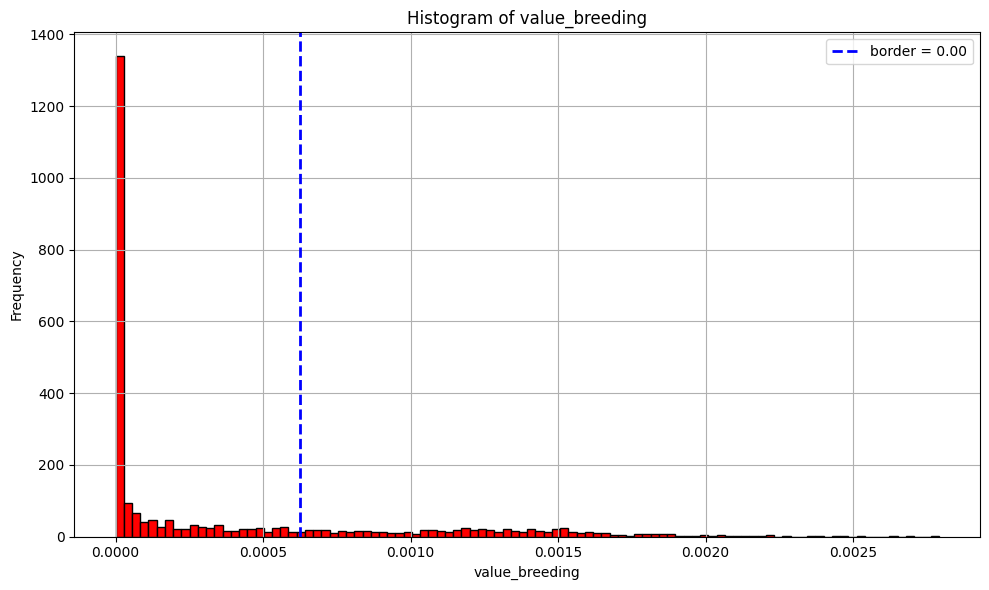

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(df["value_breeding"], bins=100, color='red', edgecolor='black')
ax.axvline(breeding_favorite_threshold, color='blue', linestyle='--', linewidth=2, label=f'threshold = {breeding_favorite_threshold:.2f}')

ax.legend()
#ax.set_ylim(0, 200) 
ax.set_title("Histogram of value_breeding")
ax.set_xlabel("value_breeding")
ax.set_ylabel("Frequency")
ax.grid(True)
fig.tight_layout()
fig.savefig(f"{species}/plots/value_breeding_hist.pdf", dpi=300, bbox_inches="tight")
plt.show()

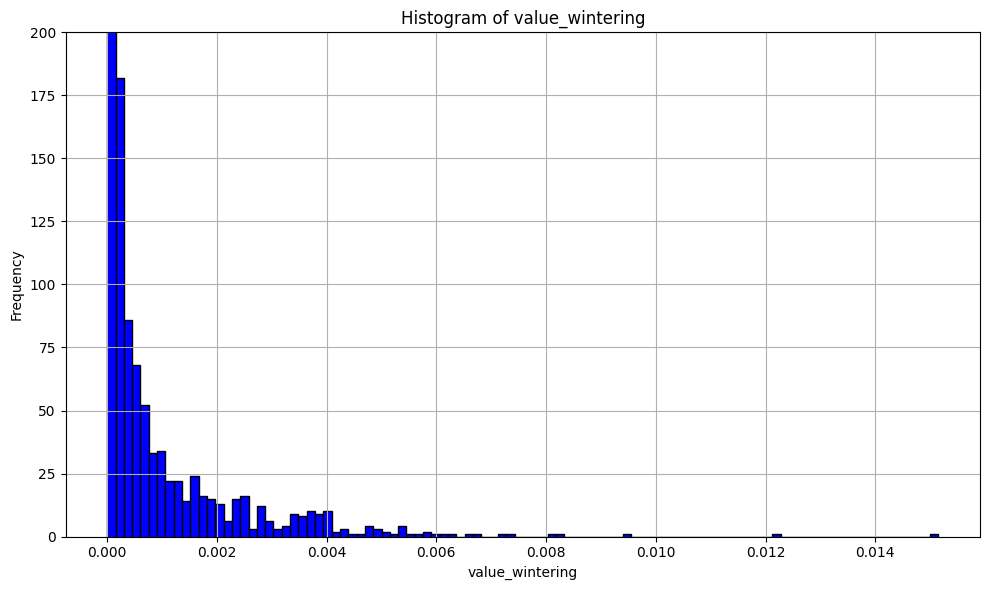

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(df["value_wintering"], bins=100, color='blue', edgecolor='black')
ax.set_ylim(0, 200)  # This avoids using plt.ylim
ax.set_title("Histogram of value_wintering")
ax.set_xlabel("value_wintering")
ax.set_ylabel("Frequency")
ax.grid(True)
fig.tight_layout()
fig.savefig(f"{species}/plots/value_wintering_hist.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [38]:
# plot breeding abundance map
df.plot(column="value_breeding", linewidth=0.2, edgecolor=None, figsize=(30, 10), legend=True)
plt.savefig(f"{species}/plots/h3_b.pdf", dpi=300, bbox_inches="tight")
plt.close()

In [39]:
# plot wintering abundance map
df.plot(column="value_wintering", linewidth=0.2, edgecolor=None, figsize=(30, 10), legend=True)
plt.savefig(f"{species}/plots/h3_w.pdf", dpi=300, bbox_inches="tight")
plt.close()

In [40]:
# plot difference map
df["diff"] = df["value_breeding"] / df["value_breeding"].max()  - df["value_wintering"] / df["value_wintering"].max()

# Determine the symmetric range around zero
max_abs = np.nanmax(np.abs(df["diff"]))
vmin, vmax = -1, 1

ax = df.plot(
    column="diff",
    linewidth=0,
    edgecolor=None,
    legend=True,
    cmap="coolwarm",  # diverging for positive/negative differences
    figsize=(30, 10),
    vmin=vmin,
    vmax=vmax  # ensures zero is in the center
)
plt.title("Breeding - Wintering")
plt.savefig(f"{species}/plots/h3_diff_norm.pdf", dpi=300, bbox_inches="tight")
plt.close()


In [41]:
# coordinates
latlng_map = df['cell'].apply(lambda c: pd.Series(h3.cell_to_latlng(c), index=['lat', 'lng']))
df = pd.concat([df, latlng_map], axis=1)

In [42]:
df = df.loc[:, ~df.columns.duplicated()]
df.head()

,value_wintering,value_breeding,cell,geometry,diff,lat,lng
0,0.0,1.713900e-06,8402083ffffffff,"POLYGON ((-97.78715 76.9892, -98.67391 76.8480...",0.000075,76.752956,-97.724852
1,0.0,1.720090e-05,8402087ffffffff,"POLYGON ((-99.63408 76.93947, -100.49651 76.79...",0.000755,76.703990,-99.541961
2,0.0,4.151879e-05,84020a3ffffffff,"POLYGON ((-102.16492 76.48973, -102.97143 76.3...",0.001824,76.254876,-102.035991
3,0.0,2.632756e-07,84020abffffffff,"POLYGON ((-101.46115 76.8769, -102.29801 76.72...",0.000012,76.642387,-101.340035
4,0.0,2.906372e-05,84020b1ffffffff,"POLYGON ((-99.36645 76.23135, -100.19132 76.08...",0.001277,75.994205,-99.282780


In [43]:
df.to_csv(f'{species}/tables/h3_abundance.csv', index = False)

# A* algorigthm for routes

## Obstacles generation from maps

In [5]:
from h3 import LatLngPoly

### Polygon

In [120]:
boundary = [
    (40, -90),
    (40, -80),
    (39, -80),
    (39, -90)
]


# Create the polygon shape
polygon = LatLngPoly(boundary)

In [121]:
barriers = h3.polygon_to_cells(polygon, resolution)

In [125]:
barriers[:5]

['842a915ffffffff',
 '842a911ffffffff',
 '84266cdffffffff',
 '84266c9ffffffff',
 '8426623ffffffff']

In [133]:
# Optional: swap (lat, lng) to (lng, lat) if needed
def swap_coords(coords):
    return [(lon, lat) for lat, lon in coords]

# Convert H3 cells to polygons
def h3_cells_to_gdf(cells):
    polygons = [Polygon(swap_coords(h3.cell_to_boundary(c))) for c in cells]
    return gpd.GeoDataFrame(geometry=polygons, crs="EPSG:4326")

In [ ]:
# Create GeoDataFrame for barriers
barrier_gdf = h3_cells_to_gdf(barriers)

# Plot base layer
ax = df.plot(
    column="value_breeding",
    linewidth=0.2,
    edgecolor=None,
    figsize=(30, 10),
    legend=True
)

# Overlay barriers in red
barrier_gdf.plot(ax=ax, facecolor="red", edgecolor="red", alpha=0.5, linewidth=0.5)

# Save the combined plot
plt.savefig(f"{species}/plots/barriers.pdf", dpi=300, bbox_inches="tight")
plt.close()

### Elevation map

In [6]:
dem_directory = 'gt30'

In [7]:
tiles = []
for filename in os.listdir(dem_directory):
    filepath = os.path.join(dem_directory, filename)
    raster_tile = rasterio.open(filepath)
    tiles.append(raster_tile)

In [8]:
from rasterio.merge import merge

In [9]:
elevation, elevation_transform = merge(tiles)

In [10]:
tiles[0].profile

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 4800, 'height': 6000, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.00833333333333, 0.0, 20.000000000000004,
       0.0, -0.00833333333333, 90.0), 'blockxsize': 4800, 'blockysize': 1, 'tiled': False, 'interleave': 'band'}

In [11]:
nodata = tiles[0].profile['nodata']

In [12]:
mask = np.where((elevation == nodata) | (elevation > elevation_limit), 1, 0)

In [13]:
factor = 10  # adjust as needed
elevation_small = elevation.squeeze()[::factor, ::factor]

plt.figure(figsize=(12, 8))
plt.imshow(elevation_small, cmap="viridis", origin="upper")
plt.colorbar(label="Value")
plt.title("Elevation (Downsampled)")

plt.savefig(f"{species}/plots/elevation_raster.pdf", dpi=300, bbox_inches="tight")
plt.close()

In [112]:
factor = 10  # adjust as needed
elevation_small = mask.squeeze()[::factor, ::factor]

plt.figure(figsize=(12, 8))
plt.imshow(elevation_small, cmap="viridis", origin="upper")
plt.colorbar(label="Value")
plt.title("Border Raster (Downsampled)")

plt.savefig(f"{species}/plots/elevation_border_raster.pdf", dpi=300, bbox_inches="tight")
plt.close()

In [14]:
elevation_res = nearest_h3_resolution(elevation[0].shape, elevation_transform, search_mode="smaller_than_pixel")
elevation_res

9

In [15]:
resolution_factor = 0.1
height, width = mask[0].shape
new_shape = (int(height * resolution_factor), int(width * resolution_factor))
downscaled = np.empty(new_shape, dtype=mask.dtype)

barriers_raster = reproject(
    source=mask,
    destination=downscaled,
    src_transform=elevation_transform,
    src_crs="EPSG:4326",
    dst_transform=elevation_transform * elevation_transform.scale(1/resolution_factor),
    dst_crs="EPSG:4326",
    resampling=Resampling.nearest
)

In [16]:
elevation_res = nearest_h3_resolution(barriers_raster[0].shape, barriers_raster[1], search_mode="smaller_than_pixel")
elevation_res

6

In [17]:
elevation_df = raster_to_dataframe(
    barriers_raster[0],
    barriers_raster[1],
    h3_resolution=elevation_res,
    compact=False,
    geo=True
)

In [18]:
elevation_df["value"] = elevation_df["value"].fillna(0)

In [19]:
elevation_df["parent"] = h3ronpy.change_resolution(elevation_df["cell"], resolution).to_numpy()

In [20]:
len(elevation_df)

13179155

In [21]:
len(elevation_df) - elevation_df['value'].sum()

np.int64(3455925)

In [22]:
elevation_df.head()

,value,cell,geometry,parent
0,1,603482350201864191,"POLYGON ((37.98599 79.21043, 38.15556 79.21843...",594475159402840063
1,1,603482350336081919,"POLYGON ((37.89067 79.26631, 38.06106 79.27437...",594475159402840063
2,1,603482350470299647,"POLYGON ((38.28714 79.19441, 38.45677 79.20224...",594475159402840063
3,1,603482350604517375,"POLYGON ((38.19355 79.25038, 38.364 79.25828, ...",594475159402840063
4,1,603482350738735103,"POLYGON ((37.7801 79.17037, 37.94881 79.17847,...",594475159402840063


In [23]:
elevation_df = elevation_df.groupby("parent", as_index=False).agg({
    "value": "min"
})

In [24]:
elevation_df = elevation_df[(elevation_df["value"] != 0)]

In [25]:
elevation_df['cell'] = elevation_df['parent'].apply(lambda x: '{:x}'.format(x))

In [26]:
def swap_coords(coords):
    return [(lon, lat) for lat, lon in coords]

In [27]:
elevation_df["geometry"] = elevation_df["cell"].apply(lambda c: Polygon(swap_coords(h3.cell_to_boundary(c))))
elevation_df.head()

,parent,value,cell,geometry
0,594475159402840063,1,8400001ffffffff,POLYGON ((37.766293232309394 79.01879305290238...
1,594475167992774655,1,8400003ffffffff,"POLYGON ((37.08186066491649 79.4085712163791, ..."
2,594475176582709247,1,8400005ffffffff,"POLYGON ((39.821706055974985 78.9019302644216,..."
3,594475185172643839,1,8400007ffffffff,"POLYGON ((39.22084486674897 79.29640634342562,..."
4,594475193762578431,1,8400009ffffffff,"POLYGON ((36.39046663786997 78.73611355290785,..."


In [28]:
elevation_df = gpd.GeoDataFrame(elevation_df.drop(columns=["parent"]), geometry="geometry", crs="EPSG:4326")

In [29]:
def no_crossing_antimeridian(geom):
    minx, miny, maxx, maxy = geom.bounds
    return (maxx - minx) <= 180

In [30]:
elevation_no_cross = elevation_df[elevation_df.geometry.apply(no_crossing_antimeridian)]

In [31]:
# plot breeding abundance map
elevation_no_cross.plot(column="value", linewidth=0.2, edgecolor=None, figsize=(30, 10), legend=True)
plt.savefig(f"{species}/plots/elevation_barriers.pdf", dpi=300, bbox_inches="tight")
plt.close()

## Pathfinding

In [32]:
import heapq

In [33]:
def a_star(origin, target, barriers):
    if not target or target in barriers:
        return []

    # Priority queue: (priority, h3Index)
    frontier = [(0, origin)]
    came_from = {origin: None}
    cost_so_far = {origin: 0}

    while frontier:
        _, current = heapq.heappop(frontier)
        if current == target:
            break

        # Get neighbors excluding barriers
        neighbors = [h for h in h3.grid_ring(current, 1) if h != current and h != None and h not in barriers]

        for neighbor in neighbors:
            new_cost = cost_so_far[current] + 1
            if neighbor not in cost_so_far or new_cost < cost_so_far[neighbor]:
                cost_so_far[neighbor] = new_cost
                priority = new_cost + h3.great_circle_distance(h3.cell_to_latlng(neighbor), h3.cell_to_latlng(target), unit='km')
                heapq.heappush(frontier, (priority, neighbor))
                came_from[neighbor] = current

    # Reconstruct path
    if target not in came_from:
        return []

    path = []
    current = target
    while current != origin:
        path.append(current)
        current = came_from[current]
    path.reverse()

    return path

In [34]:
barriers = set(elevation_no_cross['cell'].astype(str))

In [37]:
path = a_star('8442c47ffffffff', '8414857ffffffff', barriers)

In [39]:
len(path)

193

In [224]:
origin = '8442c47ffffffff'
target = '8414857ffffffff'

In [225]:
print(origin, target)
print(list(barriers)[:5])

8442c47ffffffff 8414857ffffffff
['844e917ffffffff', '84982e1ffffffff', '8450f3bffffffff', '84ccccbffffffff', '84bd409ffffffff']


In [226]:
# Create GeoDataFrame for barriers
barrier_gdf = h3_cells_to_gdf(barriers)
path_gdf = h3_cells_to_gdf(path)

# Plot base layer
ax = df.plot(
    column="value_breeding",
    linewidth=0.2,
    edgecolor=None,
    figsize=(30, 10),
    legend=True
)

# Overlay barriers in red
barrier_gdf.plot(ax=ax, facecolor="red", edgecolor="red", alpha=0.5, linewidth=0.5)
path_gdf.plot(ax=ax, facecolor="blue", edgecolor="blue", alpha=0.5, linewidth=0.5)

ax.set_xlim((60, 150))

# Save the combined plot
plt.savefig(f"{species}/plots/path.pdf", dpi=300, bbox_inches="tight")
plt.close()

# all routes

In [35]:
# TODO ?? not needed really and hardcoded everywhere else anyway...
DEPARTURE_VALUE = 'value_wintering'
DESTINATION_VALUE = 'value_breeding'

In [62]:
def generate_all_possible_routes(barriers=None):
    try:
        if barriers is None:
            all_routes = pd.read_csv(f'{species}/tables/{species}_all_routes.csv')
        else:
            all_routes = pd.read_csv(f'{species}/tables/{species}_all_routes_{elevation_limit}.csv')
    except (FileNotFoundError, pd.errors.EmptyDataError):
        df_filtered = df[(df[DEPARTURE_VALUE] > 0) & (df[DESTINATION_VALUE] > 0)]
        dict = df_filtered.set_index('cell').to_dict(orient='index')
        # Create all combinations of departure and destination
        departures = (
            df.loc[df[DEPARTURE_VALUE] > 0, ['cell', DEPARTURE_VALUE]]
            .rename(columns={'cell': 'departure_cell', DEPARTURE_VALUE: 'departure_value'})
        )

        destinations = (
            df.loc[df[DESTINATION_VALUE] > 0, ['cell', DESTINATION_VALUE]]
            .rename(columns={'cell': 'destination_cell', DESTINATION_VALUE: 'destination_value'})
        )

        all_routes = departures.merge(destinations, how='cross')

        # Compute distance
        if barriers is None:
            all_routes['length_km'] = all_routes.apply(
                lambda row: h3.great_circle_distance(
                    (dict[row.departure_cell]['lat'], dict[row.departure_cell]['lng']),
                    (dict[row.destination_cell]['lat'], dict[row.destination_cell]['lng']),
                    unit='km'
                ),
                axis=1
            )

            all_routes.to_csv(f'{species}/tables/{species}_all_routes.csv', index = False)
        else:
            # TODO not lenght_km
            all_routes['length_km'] = all_routes.apply(
                lambda row: len(a_star(
                    row.departure_cell,
                    row.destination_cell,
                    barriers
                )),
                axis=1
            )
            all_routes.to_csv(f'{species}/tables/{species}_all_routes_{elevation_limit}.csv', index = False)
    
    return all_routes

In [63]:
all_routes = generate_all_possible_routes(barriers)

In [64]:
all_routes.head()

,departure_cell,departure_value,destination_cell,destination_value,length_km
0,8426411ffffffff,2.369370e-07,840e481ffffffff,1.510744e-05,48
1,8426411ffffffff,2.369370e-07,840e483ffffffff,7.831742e-04,48
2,8426411ffffffff,2.369370e-07,840e487ffffffff,5.096538e-05,47
3,8426411ffffffff,2.369370e-07,840e489ffffffff,2.620432e-07,49
4,8426411ffffffff,2.369370e-07,840e48bffffffff,4.039924e-04,49


In [65]:
all_routes.shape

(1892880, 5)

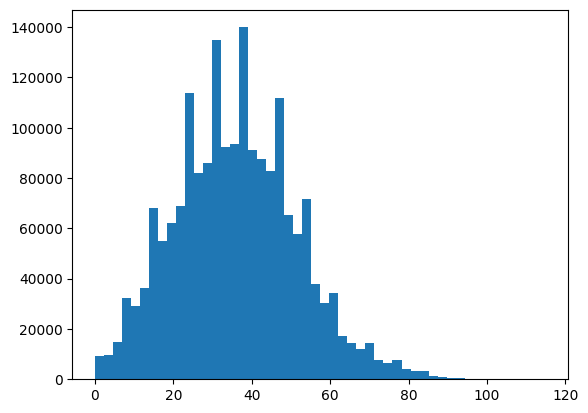

In [66]:
plt.hist(all_routes['length_km'], bins=50)
plt.show()

In [52]:
all_routes_no_barriers = generate_all_possible_routes()

In [ ]:
plt.hist(all_routes_no_barriers['length_km'], bins=50)
plt.show()

In [54]:
all_routes_old = pd.read_csv(f'{species}/tables/{species}_all_routes_old.csv')

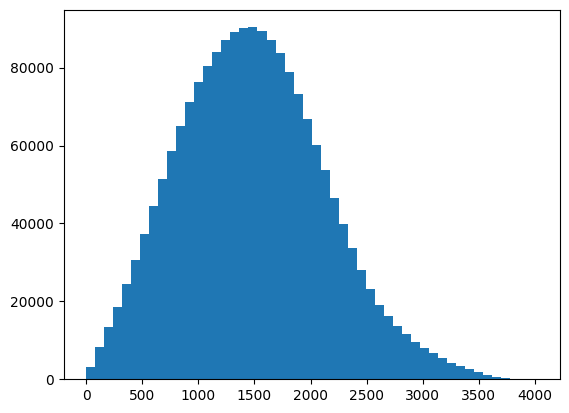

In [61]:
plt.hist(all_routes_old[(all_routes_old['departure_value'] > 0) & (all_routes_old['destination_value'] > 0)]['length_km'], bins=50)
plt.show()

# Model

In [6]:
cfg = {
    'model': 'ln_var',                # варианты 'min', 'ln', 'ln_var', 'naive'
    #'alpha': 0.01,                 # только для 'min' и 'ln'
    'algorithm': 'favorite chain' # только для 'min' и 'ln'; 
                                  # варианты: 'leapfrog', 'chain', 'fcfs', 
                                  # 'favorite leapfrog', 'favorite mix', 'favorite chain'
}

In [ ]:
def build_routes(algorithm, df, all_routes, breeding_favorite_threshold):
    if algorithm == 'fcfs':
        routes = all_routes.merge(
            df[['cell', 'value_breeding']],
            left_on='destination_cell',
            right_on='cell',
            how='left'
        )

        routes = routes.sort_values(
            by=['value_breeding', 'length_km'],
            ascending=[False, True]
        )

    elif algorithm == 'favorite leapfrog':
        routes = all_routes.merge(
            df[['cell', 'value_breeding']],
            left_on='destination_cell',
            right_on='cell',
            how='left'
        )

        favorites = routes[routes['value_breeding'] > breeding_favorite_threshold].sort_values(by='length_km', ascending=True)
        the_rest = routes[routes['value_breeding'] <= breeding_favorite_threshold].sort_values(by='length_km', ascending=True)

        routes = pd.concat([favorites, the_rest], ignore_index=True)

    elif algorithm == 'favorite mix':
        # TODO check this
        routes = all_routes.merge(
            df[['cell', 'value_breeding']],
            left_on='destination_cell',
            right_on='cell',
            how='left'
        ).drop(columns=['cell'])

        merged = routes.merge(
            df[['cell', 'lat']],
            left_on='departure_cell',
            right_on='cell',
            how='left'
        ).drop(columns=['cell'])

        favorites = merged[merged['value_breeding'] > breeding_favorite_threshold].sort_values(by='length_km', ascending=True)
        the_rest = merged[merged['value_breeding'] <= breeding_favorite_threshold]

        max_distance = the_rest['length_km'].max()
        max_lat = the_rest['lat'].max()
        min_lat = the_rest['lat'].min()

        penalty = max_distance * (1 - (max_lat - the_rest['lat']) / (max_lat - min_lat))
        
        the_rest['length_km'] += penalty
        the_rest = the_rest.sort_values(by='length_km', ascending=True)
        
        routes = pd.concat([favorites, the_rest], ignore_index=True)


    elif algorithm == 'favorite chain':
        # TODO check this
        routes = all_routes.merge(
            df[['cell', 'value_breeding']],
            left_on='destination_cell',
            right_on='cell',
            how='left'
        ).drop(columns=['cell'])

        merged = routes.merge(
            df[['cell', 'lat']],
            left_on='departure_cell',
            right_on='cell',
            how='left'
        ).drop(columns=['cell'])

        favorites = merged[merged['value_breeding'] > breeding_favorite_threshold].sort_values(by='length_km', ascending=True)
        the_rest = merged[merged['value_breeding'] <= breeding_favorite_threshold]

        max_distance = favorites['length_km'].max()
        max_lat = favorites['lat'].max()
        min_lat = favorites['lat'].min()

        penalty = max_distance * (1 - (max_lat - favorites['lat']) / (max_lat - min_lat))
        favorites['length_km'] += penalty
        favorites = favorites.sort_values(by='length_km', ascending=True)

        max_distance = the_rest['length_km'].max()
        max_lat = the_rest['lat'].max()
        min_lat = the_rest['lat'].min()

        penalty = max_distance * (1 - (max_lat - the_rest['lat']) / (max_lat - min_lat))
        the_rest['length_km'] += penalty
        the_rest = the_rest.sort_values(by='length_km', ascending=True)
        
        routes = pd.concat([favorites, the_rest], ignore_index=True)


    else: 
        routes = all_routes.copy()
        if algorithm == 'chain':
            # Merge once
            merged = all_routes.merge(
                df[['cell', 'lat']],
                left_on='departure_cell',
                right_on='cell',
                how='left'
            ).drop(columns=['cell'])

            max_distance = merged['length_km'].max()
            max_lat = merged['lat'].max()
            min_lat = merged['lat'].min()

            penalty = max_distance * (1 - (max_lat - merged['lat']) / (max_lat - min_lat))

            merged['length_km'] += penalty
            routes = merged.sort_values(by='length_km')

        elif algorithm == 'leapfrog':
            routes = routes.sort_values(by='length_km')
        
        else:
            raise ValueError("no such algorithm")
    
    return routes

In [8]:
def calculate_flow_naive(all_routes):
    routes = all_routes.copy()
    routes['flow'] = routes['departure_value'] * routes['destination_value']
    return routes

In [9]:
def calculate_flow_min(df, routes, alpha):
    dict = df.set_index('cell').to_dict(orient='index')
    
    flows = []
    for row in routes.itertuples(index=True):
        f = min(alpha * dict[row.departure_cell]['value_wintering'],
                dict[row.destination_cell]['value_breeding'])
        flows.append(f)

        dict[row.departure_cell]['value_wintering'] -= f
        dict[row.destination_cell]['value_breeding'] -= f

    return flows

In [10]:
def calculate_flow_ln(df, routes, alpha):
    df_copy = df.copy()
    df_copy['arrived'] = 0
    dict = df_copy.set_index('cell').to_dict(orient='index')
    
    flows = []
    for row in routes.itertuples(index=True):
        dep = dict[row.departure_cell]
        dest = dict[row.destination_cell]
        vb = dest['value_breeding']
        ar = dest['arrived']
        vw = dep['value_wintering']

        if (vb == 0):
            f = 0
        else:
            f = (np.log(1 + (ar + alpha * vw) / vb) * vb
                - np.log(1 + ar / vb) * vb)
        flows.append(f)

        dest['arrived'] += alpha * dep['value_wintering']
        dep['value_wintering'] -= f

    return flows

In [11]:
def optimize_ln(df, routes):
    def loss(df, routes, alpha):
        breeding = df.set_index('cell')['value_breeding'].copy()
        flows = np.array(calculate_flow_ln(df, routes, alpha))

        flow_df = routes.copy()
        flow_df['flow'] = flows
        flow_sum = flow_df.groupby('destination_cell')['flow'].sum()
        breeding.update(breeding.subtract(flow_sum, fill_value=0))

        return breeding.abs().sum()

    result = minimize_scalar(
        lambda alpha: loss(df, routes, alpha),
        bounds=(1e-6, 1.0),
        method='bounded'
    )

    return result.x, result.fun

In [12]:
def calculate_flow_ln_var(df, routes, alpha):
    df_copy = df.copy()
    df_copy['arrived'] = 0
    dict = df_copy.set_index('cell').to_dict(orient='index')
    max_lat = routes['lat'].max()
    min_lat = routes['lat'].min()

    def landing_prob(lat):
        return alpha[0] + (1 - alpha[0]) / (1 + np.exp(alpha[2] * (- (lat - min_lat) / (max_lat - min_lat) + alpha[1])))
    
    flows = []
    for row in routes.itertuples(index=True):
        dep = dict[row.departure_cell]
        dest = dict[row.destination_cell]
        vb = dest['value_breeding']
        ar = dest['arrived']
        vw = dep['value_wintering']

        if (vb == 0):
            f = 0
        else:
            f = (np.log(1 + (ar + landing_prob(row.lat) * vw) / vb) * vb
                - np.log(1 + ar / vb) * vb)
        flows.append(f)

        dest['arrived'] += landing_prob(row.lat) * dep['value_wintering']
        dep['value_wintering'] -= f

    return flows

In [13]:
def optimize_ln_var(df, routes):
    def loss(df, routes, alpha):
        breeding = df.set_index('cell')['value_breeding'].copy()
        flows = np.array(calculate_flow_ln_var(df, routes, alpha))

        flow_df = routes.copy()
        flow_df['flow'] = flows
        flow_sum = flow_df.groupby('destination_cell')['flow'].sum()
        breeding.update(breeding.subtract(flow_sum, fill_value=0))

        return breeding.abs().sum()

    alpha0 = [1, 1e-6, 1]
    result = minimize(
        lambda alpha: loss(df, routes, alpha),
        alpha0,
        bounds=[(1e-6, 1.0),(1e-6, 1.0),(1, 100)],
        method='L-BFGS-B'
    )

    return result.x, result.fun

In [14]:
def model(cfg, df, all_routes, breeding_favorite_threshold):
    if cfg['model'] == 'naive':
        return calculate_flow_naive(df, all_routes)

    routes = build_routes(cfg['algorithm'], df, all_routes, breeding_favorite_threshold)

    if cfg['model'] == 'min':
        routes['flow'] = calculate_flow_min(df, routes, cfg['alpha'])
        return routes

    if cfg['model'] == 'ln':
        alpha_opt, loss_opt = optimize_ln(df, routes)
        print(f"Optimal alpha: {alpha_opt:.6f}, loss: {loss_opt:.4f}")
        routes['flow'] = np.array(calculate_flow_ln(df, routes, alpha_opt))
        return routes
    
    if cfg['model'] == 'ln_var':
        alpha_opt, loss_opt = optimize_ln_var(df, routes)
        print(f"Optimal alpha: {alpha_opt}, loss: {loss_opt:.4f}")
        routes['flow'] = np.array(calculate_flow_ln_var(df, routes, alpha_opt))
        return routes

    raise ValueError(f"Unknown model {cfg['model']}")

## Эксперименты с amewoo и alpha

In [95]:
# routes = model(cfg, df, all_routes, breeding_favorite_threshold)

[3.49670107e-03 9.73051614e-01 9.99999756e+01], loss: 0.2988

In [18]:
routes = build_routes(cfg['algorithm'], df, all_routes, breeding_favorite_threshold)

/tmp/ipykernel_855249/822142936.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  the_rest['length_km'] += penalty


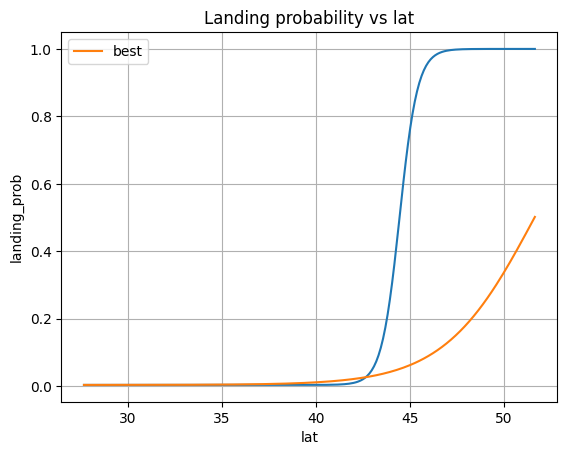

In [94]:
alpha_best = [0.0035, 1, 10]
alpha = [0.0035, 0.7, 50]

max_lat = routes['lat'].max()
min_lat = routes['lat'].min()

def landing_prob(alpha, lat):
    return alpha[0] + (1 - alpha[0]) / (1 + np.exp(alpha[2] * (- (lat - min_lat) / (max_lat - min_lat) + alpha[1])))

x = np.linspace(min_lat, max_lat, 200)
y_best = [landing_prob(alpha_best, xi) for xi in x]
y = [landing_prob(alpha, xi) for xi in x]

plt.plot(x, y)
plt.plot(x, y_best, label='best')
plt.xlabel("lat")
plt.ylabel("landing_prob")
plt.title("Landing probability vs lat")
plt.legend()
plt.grid(True)
plt.show()


In [92]:
def optimize_beta(df, routes, alpha):
    def loss(df, routes, alpha, beta):
        breeding = df.set_index('cell')['value_breeding'].copy()
        alpha[1] = beta
        flows = np.array(calculate_flow_ln_var(df, routes, alpha))

        flow_df = routes.copy()
        flow_df['flow'] = flows
        flow_sum = flow_df.groupby('destination_cell')['flow'].sum()
        breeding.update(breeding.subtract(flow_sum, fill_value=0))

        return breeding.abs().sum()

    result = minimize_scalar(
        lambda beta: loss(df, routes, alpha, beta),
        bounds=(1e-6, 1.0),
        method='bounded'
    )

    return result.x, result.fun

In [93]:
print(optimize_beta(df, routes, [0.0035, 1, 50]))

(np.float64(0.7075625327866557), np.float64(0.3020241824109391))


In [83]:
# alpha = [0.0035, 1, 10]

alpha = [0.0035, 0.4, 50]
routes['flow'] = np.array(calculate_flow_ln_var(df, routes, alpha))

In [84]:
def loss(df, routes):
        breeding = df.set_index('cell')['value_breeding'].copy()

        flow_sum = routes.groupby('destination_cell')['flow'].sum()
        breeding.update(breeding.subtract(flow_sum, fill_value=0))

        return breeding.abs().sum()

In [85]:
print(loss(df, routes))

0.6202800261338579


In [86]:
routes_nonzero = routes[routes["flow"] != 0]

In [87]:
print(routes_nonzero.flow.sum())

0.9801933202162261


In [61]:
routes_nonzero.head()

,departure_cell,departure_value,destination_cell,destination_value,length_km,value_breeding,lat,flow
0,8444a81ffffffff,1.836466e-05,842a80bffffffff,0.000697,1321.120259,0.000697,27.694317,6.427333e-08
1,8444a8bffffffff,1.456728e-07,842a80bffffffff,0.000697,1325.576250,0.000697,27.728246,5.098075e-10
2,8444a83ffffffff,2.209088e-06,842a80bffffffff,0.000697,1338.848353,0.000697,28.061154,7.731048e-09
3,8444a9dffffffff,1.741546e-06,842a80bffffffff,0.000697,1343.926634,0.000697,28.095667,6.094752e-09
4,8444a99ffffffff,1.523360e-05,842a80bffffffff,0.000697,1350.149240,0.000697,28.129110,5.330955e-08


In [62]:
routes_nonzero.shape

(1777626, 8)

## save routes 

In [40]:
def save_routes(routes, species, cfg):
    
    model_name = cfg['model']
    algorithm = cfg.get('algorithm')
    alpha = cfg.get('alpha')
    
    base_dir = f"{species}/tables/{model_name}"
    if algorithm is not None:
        base_dir = os.path.join(base_dir, algorithm)
    
    os.makedirs(base_dir, exist_ok=True)
    
    file_name = f"{model_name}"
    if algorithm is not None:
        file_name += f" {algorithm}"
    if alpha is not None:
        file_name += f" {alpha}"
    file_name += ".csv"

    routes.to_csv(os.path.join(base_dir, file_name), index=False)


In [ ]:
save_routes(routes_nonzero, species, cfg)

# Plots

In [ ]:
# routes_nonzero = pd.read_csv(f"{species}/tables/{model}/{model}_{alpha}.csv")
routes_nonzero = pd.read_csv(f'/home/gkim/birds/{species}/tables/ln/favorite chain/ln favorite chain.csv')

In [41]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.animation import FuncAnimation
from ipywidgets import interact, IntSlider, Output, interactive, Play, VBox, jslink
from IPython.display import HTML

In [42]:
# %matplotlib widget

In [63]:
df_plot = df.copy()
df_plot["abundance"] = df_plot["value_wintering"].copy()
df_plot.drop(columns=["value_breeding", "value_wintering", "diff", "lat", "lng"], inplace=True)

In [64]:
batch_size = 100000

In [65]:
# cache = [df_plot.copy()]

# for start in range(0, len(routes_nonzero), batch_size):
#     end = min(start + batch_size, len(routes_nonzero))

#     # Apply flows up to the current step
#     flows = routes_nonzero[start:end].groupby("departure_cell")["flow"].sum()
#     df_plot.loc[df_plot["cell"].isin(flows.index), "abundance"] -= df_plot["cell"].map(flows).astype("float32")

#     flows = routes_nonzero[start:end].groupby("destination_cell")["flow"].sum()
#     df_plot.loc[df_plot["cell"].isin(flows.index), "abundance"] += df_plot["cell"].map(flows).astype("float32")

#     cache.append(df_plot.copy())

In [66]:
cache = [df_plot.copy()]

cells = df_plot.set_index("cell")  # fast lookup by cell

for start in range(0, len(routes_nonzero), batch_size):
    end = min(start + batch_size, len(routes_nonzero))
    batch = routes_nonzero.iloc[start:end]

    # Net flow per cell in this batch: -departures + arrivals
    net_flows = (
        batch.groupby("departure_cell")["flow"].sum().rename("outflow").mul(-1)
        .add(batch.groupby("destination_cell")["flow"].sum(), fill_value=0)
    )

    # Update abundances in place
    cells.loc[net_flows.index, "abundance"] += net_flows.astype("float32")

    cache.append(cells.reset_index().copy())

In [67]:
len(cache)

19

In [68]:
cache[-1].head()

,cell,geometry,abundance
0,840e481ffffffff,"POLYGON ((-68.5664 50.60941, -68.96035 50.5717...",0.000044
1,840e483ffffffff,"POLYGON ((-68.47423 50.18301, -68.86416 50.145...",0.000615
2,840e487ffffffff,"POLYGON ((-69.1078 50.33935, -69.499 50.29987,...",0.000094
3,840e489ffffffff,"POLYGON ((-68.01836 50.87713, -68.41503 50.841...",0.000002
4,840e48bffffffff,"POLYGON ((-67.93136 50.44978, -68.32394 50.414...",0.000201


In [69]:
# plot difference map
df_res = cache[-1].copy()
df_res["abundance"] = df["value_breeding"] - df_res["abundance"]

# Determine the symmetric range around zero
max_abs = np.nanmax(np.abs(df_res["abundance"]))
vmin, vmax = -max_abs, max_abs

ax = df_res.plot(
    column="abundance",
    linewidth=0,
    edgecolor=None,
    legend=True,
    cmap="coolwarm",  # diverging for positive/negative differences
    figsize=(30, 10),
    vmin=vmin,
    vmax=vmax  # ensures zero is in the center
)
plt.title("true_value_breeding - abundance")


# name
plt.savefig(f"{species}/plots/res_custom_alpha.pdf", dpi=300, bbox_inches="tight")
plt.close()


## Prerendered animation

In [70]:
import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 50 * 1024**2  # 50 MB

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=150)
vmax = np.nanmax(df[["value_breeding", "value_wintering"]])
norm=plt.Normalize(vmin=0, vmax=vmax)
plt.tight_layout()
sm = plt.cm.ScalarMappable(cmap="magma_r", norm=norm)
fig.colorbar(sm, ax=ax)

# Initial plot
plot = cache[0].plot(
    column="abundance",
    cmap="magma_r",
    linewidth=0.2,
    edgecolor="black",
    ax=ax,
    legend=False,
    norm=norm
)

# --- Animation update function ---
def update(step):
    df_step = cache[step]
    new_values = df_step["abundance"].values
    new_norm = plt.Normalize(vmin=0, vmax=new_values.max())
    
    sm.set_norm(new_norm)
    c = ax._children[0]
    c.set_array(new_values)
    c.set_norm(new_norm)

    ax.set_title(f"Abundance after {step} steps")

    return [c]

# Reduce frames if needed for memory
frame_indices = range(0, len(cache), 1)  # use step>1 if cache is huge

ani = FuncAnimation(
    fig,
    update,
    frames=frame_indices,
    interval=100,
    blit=False,  # blit=True can cause issues in Jupyter, False is safe
    repeat=False
)

# Display animation
display(HTML(ani.to_jshtml()))
plt.close(fig)

In [199]:
ani.save(f"{species}/plots/ln_{model}.gif", writer="pillow", fps=10)
#ani.save(f"{species}/plots/{model}_{alpha}.gif", writer="pillow", fps=10)